# Kaggle Competition Titanic

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import raw Data
test_data = pd.read_csv("test.csv")
train_data = pd.read_csv("train.csv")
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


From first glance, we have different types of data. We will need to convert some categorical ones into numerical ones to make things easier for ML models. 

We need to determine what is missing and clean the data by resolving missing data and changing the categorical data to numerical ones. 

In [3]:
# Let's see how many values are missing 
train_data.isnull().sum()

# We can see that there are a lot of cabin values missing and some age data missing. 
# Embark are only two missing values which might be resolved. 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Data Exploration / Exploratory Analysis

Let's look at each variable and see if there's anything to resolve or change to make ML models train and perform better. 

In [4]:
# Let's create two dataframes splitting it up survived and not survived. 
not_survived = train_data[train_data['Survived'] == 0]
survived = train_data[train_data['Survived'] == 1]

### Age

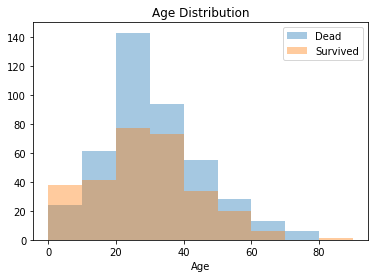

In [5]:
# There are currently missing 177 age values. Moreover, the age values are specific numbers. 
# We can change these numbers to range bins and then change them to numerical values when we clean the data/

# Let's see what the data looks like for male and female with respect to surivival 

fig, ax = plt.subplots()
for age_lists in [not_survived['Age'].dropna(), survived['Age'].dropna()]:
    sns.distplot(age_lists, bins = np.arange(0,100,10),kde=False)
ax.legend(labels=['Dead', 'Survived'])
ax.set_title("Age Distribution")
plt.show()


### Sex

In [6]:
dead_sex_count = []
survived_sex_count = []

for i in sorted(set(not_survived['Sex'].unique())):
    dead_sex_count.append(not_survived[not_survived['Sex'] == i].shape[0])

for i in sorted(set(survived['Sex'].unique())):
    survived_sex_count.append(survived[survived['Sex'] == i].shape[0])

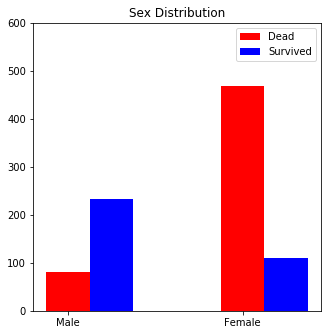

In [7]:
fig = plt.figure(figsize = (4,4))
data = [dead_sex_count,
survived_sex_count]
X = np.arange(2)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'r', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'b', width = 0.25)
ax.set_yticks(np.arange(0,700,100))
plt.xticks(X, ('Male', 'Female'))
ax.legend(labels=['Dead', 'Survived'])
ax.set_title("Sex Distribution")
plt.show()

### Class

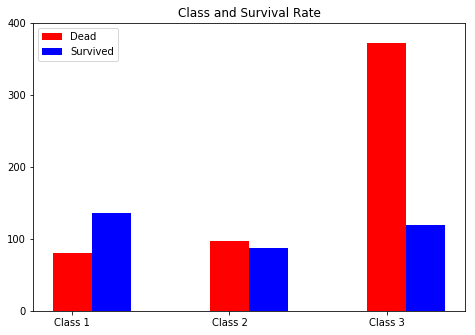

In [8]:
# Determine count of people within each Pclass from the died and survived dataframe
dead_pclass_count = []
survived_pclass_count = []
counter = 0;
for i in sorted(set(not_survived['Pclass'].unique())):
    dead_pclass_count.append(not_survived[not_survived['Pclass'] == i].shape[0])

for i in sorted(set(survived['Pclass'].unique())):
    survived_pclass_count.append(survived[survived['Pclass'] == i].shape[0])
    
fig = plt.figure()
data = [dead_pclass_count,
survived_pclass_count]
X = np.arange(3)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'r', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'b', width = 0.25)
ax.set_yticks(np.arange(0,500,100))
plt.xticks(X, ('Class 1', 'Class 2', 'Class 3'))
ax.legend(labels=['Dead', 'Survived'])
plt.title('Class and Survival Rate')
plt.show()

### Dead vs Survived with relation to family 

#### Siblings

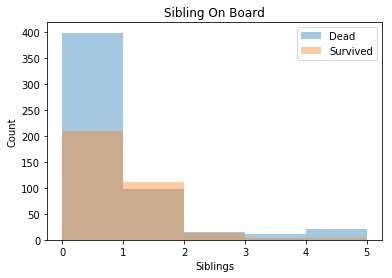

In [9]:
dead_sib_count = not_survived['SibSp']
survived_sib_count = survived['SibSp']

fig, ax = plt.subplots()
for sibling_lists in [dead_sib_count, survived_sib_count]:
    sns.distplot(sibling_lists, bins = np.arange(0, 6, 1),kde=False)
ax.legend(labels=['Dead', 'Survived'])
ax.set_title("Sibling On Board")
plt.xlabel("Siblings")
plt.ylabel("Count")
plt.show()

#### Parents

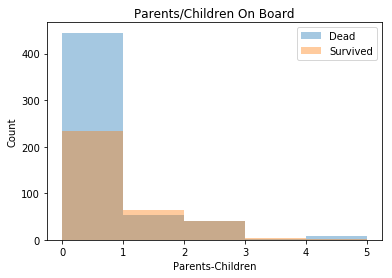

In [10]:
dead_parents_count = not_survived['Parch']
survived_parents_count = survived['Parch']

fig, ax = plt.subplots()
for parents_lists in [dead_parents_count, survived_parents_count]:
    sns.distplot(parents_lists, bins = np.arange(0, 6, 1),kde=False)
ax.legend(labels=['Dead', 'Survived'])
ax.set_title("Parents/Children On Board")
plt.xlabel("Parents-Children")
plt.ylabel("Count")
plt.show()

### Fare

In [11]:
dead_fare = not_survived['Fare']
survived_fare = survived['Fare']

expensive_fare = max(train_data['Fare'])
average_fare = np.average(train_data['Fare'])
print("Most Expensive Ticket", expensive_fare)
print("Average Ticket Price", average_fare)

Most Expensive Ticket 512.3292
Average Ticket Price 32.204207968574636


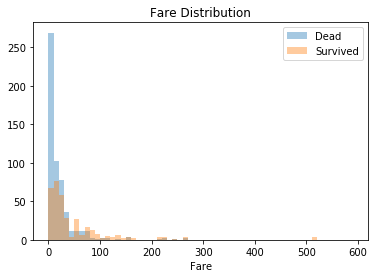

In [12]:
fig, ax = plt.subplots()
for fare_lists in [dead_fare, survived_fare]:
    sns.distplot(fare_lists, bins = np.arange(0,600,10),kde=False)
ax.legend(labels=['Dead', 'Survived'])
ax.set_title("Fare Distribution")
plt.show()

### Embark Location

In [13]:
dead_embark_count = []
survived_embark_count = []

embark_locations = sorted(set(not_survived['Embarked'].unique()))         
# print(embark_locations)

for i in embark_locations:
    dead_embark_count.append(not_survived[not_survived['Embarked'] == i].shape[0])

for i in embark_locations:
    survived_embark_count.append(survived[survived['Embarked'] == i].shape[0])

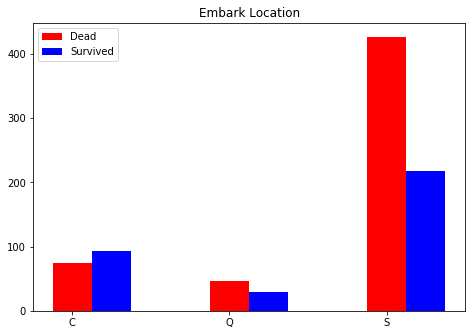

In [14]:
fig = plt.figure()
data = [dead_embark_count,
survived_embark_count]
X = np.arange(3)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'r', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'b', width = 0.25)
ax.set_yticks(np.arange(0,500,100))
plt.xticks(X, ('C', 'Q', 'S'))
ax.legend(labels=['Dead', 'Survived'])
plt.title('Embark Location')
plt.show()

## Data Processing

Here we will be processing the data for both the training data set and test data set to account for changing categorical values to numerical values, and dealing with missing data. We will also be looking into feature engineering. 

### Age

In [15]:
# let's deal with the missing values of Ages by taking the average and std of train and test data sets

# Use training data set values to estimate age
mean = train_data['Age'].mean()
std = train_data['Age'].std()

# determine the number of missing ages in both test and training data sets and fill with distribution
combined_data = [train_data, test_data]

for dataframe in combined_data:
    num_null = dataframe["Age"].isnull().sum()
    random_age_value = np.random.randint(mean-std, mean+std, num_null)
    age_data = dataframe["Age"].copy()
    age_data[np.isnan(age_data)] = random_age_value
    dataframe["Age"] = age_data
    

In [16]:
# Check if data is null 
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [17]:
# Check if data is null 
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [18]:
# Let's group the ages into categories

# Age Group
# 0-9 - 0
# 10-19 - 1
# 20-29 - 2
# 30-39 - 3
# 40-49 - 4
# 50-59 - 5
# >60 - 6

data = [train_data, test_data]
for dataframe in data:
    dataframe['Age'] = dataframe['Age'].astype(int)
    dataframe.loc[dataframe['Age'] <= 9, 'Age'] = 0
    dataframe.loc[(dataframe['Age'] >= 10) & (dataframe['Age'] <= 19) , 'Age'] = 1
    dataframe.loc[(dataframe['Age'] >= 20) & (dataframe['Age'] <= 29) , 'Age'] = 2
    dataframe.loc[(dataframe['Age'] >= 30) & (dataframe['Age'] <= 39), 'Age'] = 3
    dataframe.loc[(dataframe['Age'] >= 40) & (dataframe['Age'] <= 49) , 'Age'] = 4
    dataframe.loc[(dataframe['Age'] >= 50) & (dataframe['Age'] <= 59) , 'Age'] = 5
    dataframe.loc[dataframe['Age'] >= 60, 'Age'] = 6


In [19]:
# Check if transformation to ranges worked
train_data['Age'].value_counts()

2    288
3    223
1    137
4    107
0     62
5     48
6     26
Name: Age, dtype: int64

### Gender

In [20]:
# Map Gender to be 0 and 1 for men and female respectively

data = [train_data, test_data]
for dataframe in data:
    dataframe.loc[dataframe['Sex'] == 'male', 'Sex'] = 0
    dataframe.loc[dataframe['Sex'] == 'female', 'Sex'] = 1
    

In [21]:
# Check if transformation to ranges worked
train_data['Sex'].value_counts()

0    577
1    314
Name: Sex, dtype: int64

### Class

In [22]:
# Map classes to be:
# Class 1 to 0
# Class 2 to 1
# Class 3 to 2

data = [train_data, test_data]
for dataframe in data:
    dataframe['Pclass'] = dataframe['Pclass'].astype(int)
    dataframe.loc[dataframe['Pclass'] == 1, 'Pclass'] = 0
    dataframe.loc[dataframe['Pclass'] == 2, 'Pclass'] = 1
    dataframe.loc[dataframe['Pclass'] == 3, 'Pclass'] = 2
    

In [23]:
# Check if transformation to ranges worked
train_data['Pclass'].value_counts()

2    491
0    216
1    184
Name: Pclass, dtype: int64

In [24]:
train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,2,"Braund, Mr. Owen Harris",0,2,1,0,A/5 21171,7.2500,NaN,S
1,2,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3,1,0,PC 17599,71.2833,C85,C
2,3,1,2,"Heikkinen, Miss. Laina",1,2,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,3,1,0,113803,53.1000,C123,S
4,5,0,2,"Allen, Mr. William Henry",0,3,0,0,373450,8.0500,NaN,S


### Family

In [25]:
# We can combine SibSp and Parch to have a feature that contains family presence
# Create family which would be the sum of SibSp and Parch and then convert to boolean 

data = [train_data, test_data]
for dataframe in data:
    dataframe['SibSp'] = dataframe['SibSp'].astype(int)
    dataframe['Parch'] = dataframe['Parch'].astype(int)
    dataframe['family_count'] = dataframe['SibSp'] + dataframe['Parch']
    
    dataframe.loc[dataframe['family_count'] > 0, 'family'] = 1
    dataframe.loc[dataframe['family_count'] == 0, 'family'] = 0
    dataframe['family'] = dataframe['family'].astype(int)

### Fare

In [26]:
# We will categorize fares based on its ranges. 
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

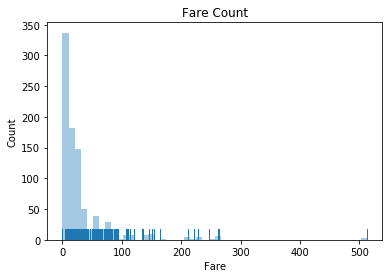

In [27]:
fig, ax = plt.subplots() 
sns.distplot(train_data["Fare"], kde=False, rug=True);
plt.title("Fare Count")
plt.ylabel("Count")
plt.show()

In [28]:
data = [train_data, test_data]
for dataframe in data:
    dataframe.loc[dataframe['Fare'] <= 7.91, 'Fare'] = 0
    dataframe.loc[(dataframe['Fare'] > 7.91) & (dataframe['Fare'] <= 14.45) , 'Fare'] = 1
    dataframe.loc[(dataframe['Fare'] > 14.45) & (dataframe['Fare'] <= 31) , 'Fare'] = 2
    dataframe.loc[(dataframe['Fare'] > 31) & (dataframe['Fare'] <= 100), 'Fare'] = 3
    dataframe.loc[(dataframe['Fare'] > 100) & (dataframe['Fare'] <= 200) , 'Fare'] = 4
    dataframe.loc[(dataframe['Fare'] > 20) , 'Fare'] = 5

In [29]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_count,family
0,1,0,2,"Braund, Mr. Owen Harris",0,2,1,0,A/5 21171,0.0,NaN,S,1,1
1,2,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3,1,0,PC 17599,3.0,C85,C,1,1
2,3,1,2,"Heikkinen, Miss. Laina",1,2,0,0,STON/O2. 3101282,1.0,NaN,S,0,0
3,4,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,3,1,0,113803,3.0,C123,S,1,1
4,5,0,2,"Allen, Mr. William Henry",0,3,0,0,373450,1.0,NaN,S,0,0
5,6,0,2,"Moran, Mr. James",0,4,0,0,330877,1.0,NaN,Q,0,0
6,7,0,0,"McCarthy, Mr. Timothy J",0,5,0,0,17463,3.0,E46,S,0,0
7,8,0,2,"Palsson, Master. Gosta Leonard",0,0,3,1,349909,2.0,NaN,S,4,1
8,9,1,2,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,2,0,2,347742,1.0,NaN,S,2,1
9,10,1,1,"Nasser, Mrs. Nicholas (Adele Achem)",1,1,1,0,237736,2.0,NaN,C,1,1


### Embarked

In [30]:
data = [train_data, test_data]
for dataframe in data:
    dataframe.loc[dataframe['Embarked'] == "C", 'Embarked'] = 0
    dataframe.loc[dataframe['Embarked'] == "Q", 'Embarked'] = 1
    dataframe.loc[dataframe['Embarked'] == "S", 'Embarked'] = 2
    

In [31]:
train_data.isna().sum()

PassengerId       0
Survived          0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           687
Embarked          2
family_count      0
family            0
dtype: int64

In [32]:
test_data.isna().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin           327
Embarked          0
family_count      0
family            0
dtype: int64

## Feature Engineering

Apart from the features introduced here, we have created new features from the raw data such as the family presence boolean, and have remapped categorical features into numerical ones. 

### Name

In [33]:
# Using names, we can extract titles of individuals which can become new features
common_titles = {"Mr": 0, "Miss": 2, "Mrs": 3, "Master":4, "Other": 5}

In [34]:
data = [train_data, test_data]

for dataframe in data:
    dataframe['Title'] = dataframe.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # replace old titles to Other
    dataframe['Title'] = dataframe['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], "Other")
    dataframe['Title'] = dataframe['Title'].replace('Mlle', 'Miss')
    dataframe['Title'] = dataframe['Title'].replace('Ms', 'Miss')
    dataframe['Title'] = dataframe['Title'].replace('Mme', 'Mrs')
    dataframe['Title'] = dataframe['Title'].map(common_titles)

In [35]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_count,family,Title
0,1,0,2,"Braund, Mr. Owen Harris",0,2,1,0,A/5 21171,0.0,NaN,2,1,1,0
1,2,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3,1,0,PC 17599,3.0,C85,0,1,1,3
2,3,1,2,"Heikkinen, Miss. Laina",1,2,0,0,STON/O2. 3101282,1.0,NaN,2,0,0,2
3,4,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,3,1,0,113803,3.0,C123,2,1,1,3
4,5,0,2,"Allen, Mr. William Henry",0,3,0,0,373450,1.0,NaN,2,0,0,0


### Age multiplied by class

In [36]:
data = [train_data, test_data]
for dataframe in data:
    dataframe['Age_times_Class'] = dataframe["Age"] * dataframe["Pclass"]

In [37]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_count,family,Title,Age_times_Class
0,1,0,2,"Braund, Mr. Owen Harris",0,2,1,0,A/5 21171,0.0,NaN,2,1,1,0,4
1,2,1,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,3,1,0,PC 17599,3.0,C85,0,1,1,3,0
2,3,1,2,"Heikkinen, Miss. Laina",1,2,0,0,STON/O2. 3101282,1.0,NaN,2,0,0,2,4
3,4,1,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,3,1,0,113803,3.0,C123,2,1,1,3,0
4,5,0,2,"Allen, Mr. William Henry",0,3,0,0,373450,1.0,NaN,2,0,0,0,6


### Drop columns

In [38]:
train_data.isna().sum()

PassengerId          0
Survived             0
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              687
Embarked             2
family_count         0
family               0
Title                0
Age_times_Class      0
dtype: int64

Because Cabin is missing a lot of values, we will choose to drop this column. Additionally, the Ticket contains random letters and numbers that might have not significance so we will drop this as well. 

Moreover, to reduce the number of features, we will be removing features that we used to engineer new features such as Name, SibSp, Parch, and family_count. PassengerId will also be removed as it does not seem to have any useful information. 

In [39]:
train_data = train_data.drop(columns=['Cabin', 'Ticket', 'Name', 'SibSp', 'Parch', 'family_count', 'PassengerId'])
test_data = test_data.drop(columns=['Cabin', 'Ticket', 'Name', 'SibSp', 'Parch', 'family_count', 'PassengerId'])

In [40]:
train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,family,Title,Age_times_Class
0,0,2,0,2,0.0,2,1,0,4
1,1,0,1,3,3.0,0,1,3,0
2,1,2,1,2,1.0,2,0,2,4
3,1,0,1,3,3.0,2,1,3,0
4,0,2,0,3,1.0,2,0,0,6


### Deal with missing values and feature types

In [41]:
train_data.isna().sum()

Survived           0
Pclass             0
Sex                0
Age                0
Fare               0
Embarked           2
family             0
Title              0
Age_times_Class    0
dtype: int64

In [42]:
test_data.isna().sum()

Pclass             0
Sex                0
Age                0
Fare               1
Embarked           0
family             0
Title              0
Age_times_Class    0
dtype: int64

For the missing data in the training data set, I will fill it with the mode of the Embarked feature. 

In [43]:
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])
train_data.isna().sum()

Survived           0
Pclass             0
Sex                0
Age                0
Fare               0
Embarked           0
family             0
Title              0
Age_times_Class    0
dtype: int64

For the missing data in the test data set, I will fill it with the mode of the Fare feature.

In [44]:
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].mode()[0])
test_data.isna().sum()

Pclass             0
Sex                0
Age                0
Fare               0
Embarked           0
family             0
Title              0
Age_times_Class    0
dtype: int64

In [45]:
train_data.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,family,Title,Age_times_Class
0,0,2,0,2,0.0,2,1,0,4
1,1,0,1,3,3.0,0,1,3,0
2,1,2,1,2,1.0,2,0,2,4
3,1,0,1,3,3.0,2,1,3,0
4,0,2,0,3,1.0,2,0,0,6
5,0,2,0,4,1.0,1,0,0,8
6,0,0,0,5,3.0,2,0,0,0
7,0,2,0,0,2.0,2,1,4,0
8,1,2,1,2,1.0,2,1,3,4
9,1,1,1,1,2.0,0,1,3,1


## Correlation Matrix to determine Feature Importance

The correlation matrix will tell us if we have good features that can help us predict the survivability of passengers. 

In [46]:
corr_data = train_data.corr()

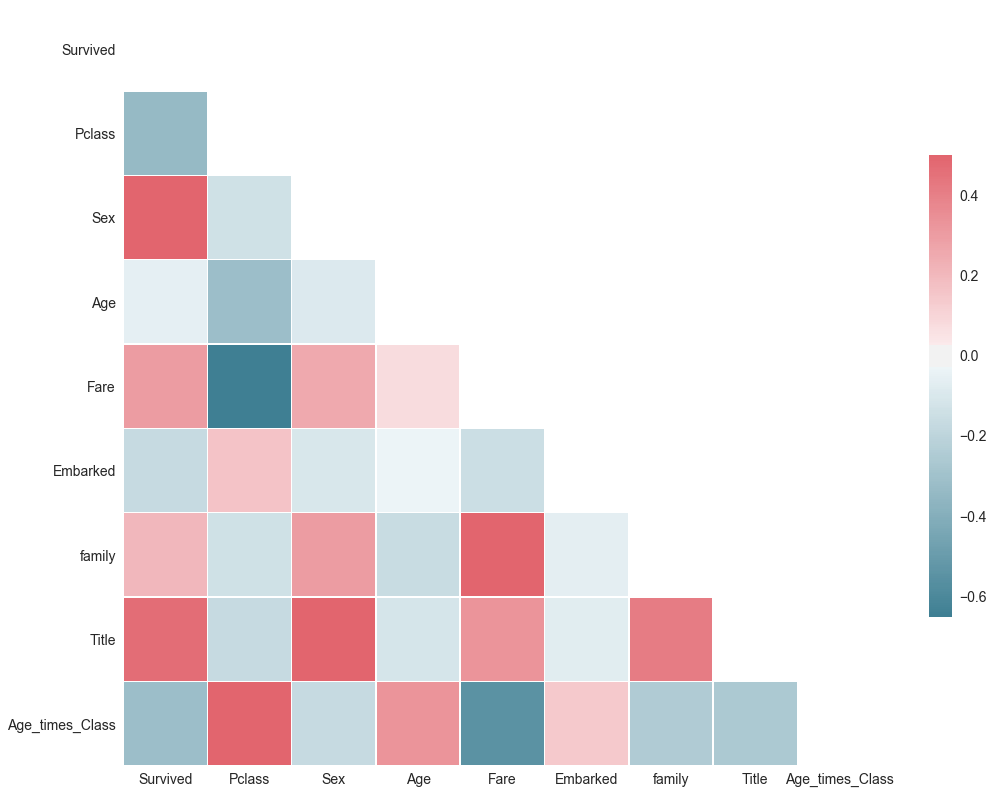

In [47]:
sns.set(style="white", font_scale = 1.4)
mask = np.zeros_like(corr_data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(17, 17))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_data, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

The correlation matrix indicates that nearly all features that were used/engineered have a strong correlation with the survival rate of passengers. 

Some to note are:
- Sex
- Title
- Fare
- Family
- Class

The relationship between survivability and these factors were seen beforehand during the exploratory analysis. 

Another way to see feature importance is by the use of a preliminary random forest model. 

In [48]:
# Create input and output using the training data set
X = train_data.drop(columns = ['Survived'], axis = 1)
Y = train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=125)

In [49]:
X.isna().sum()

Pclass             0
Sex                0
Age                0
Fare               0
Embarked           0
family             0
Title              0
Age_times_Class    0
dtype: int64

In [68]:
RF_prelim = RandomForestClassifier(n_estimators=100)
RF_prelim.fit(X_train, y_train)
pred = RF_prelim.predict(X_test)
accuracy_score(y_test, pred)

0.7649253731343284

In [61]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(RF_prelim.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
Title,0.220
Sex,0.198
Fare,0.135
Age_times_Class,0.115
Age,0.111
Pclass,0.106
Embarked,0.071
family,0.042


## Model Implementation

In this section, we will look further into tuning the random forest model. 

Earlier section is just to play around with the model. The latter section contains tuning parameters of the model. 

In [69]:
start_time = time.time()
model = RandomForestClassifier()
model.fit(X_train,y_train)
print("Training took: %s seconds" % (time.time() - start_time))

Training took: 0.011966943740844727 seconds


In [70]:
predictions = model.predict(X_test)

In [71]:
print('Accuracy: %.2f%%' % (accuracy_score(y_test, predictions)*100))

Accuracy: 78.73%


In [72]:
# Print classification report
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.77      0.91      0.83       159
          1       0.82      0.61      0.70       109

avg / total       0.79      0.79      0.78       268



In [75]:
survival_conf_matrix = confusion_matrix(y_test, predictions)
# print (survival_conf_matrix)
class_names = train_data['Survived'].unique()
class_names_label = ['negative', 'positive']

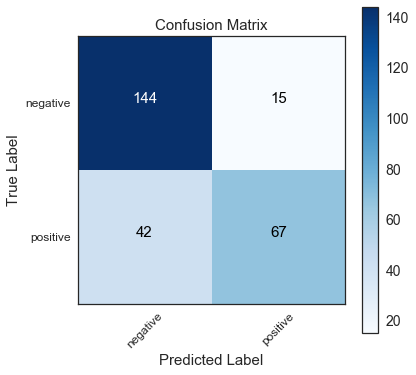

In [76]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(6,6))
plt.imshow(survival_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15)
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names_label, rotation=45, fontsize=12)
plt.yticks(tick_marks, class_names_label, fontsize=12)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)


for i in range(len(survival_conf_matrix)):
    for j in range(len(survival_conf_matrix[i])):
        color = 'black'   
        if survival_conf_matrix[i][j] > 100:
            color = 'white'
        plt.text(j, i, format(survival_conf_matrix[i][j]), 
                horizontalalignment='center',
                color=color, fontsize=15)

Area under the ROC curve: 0.795633


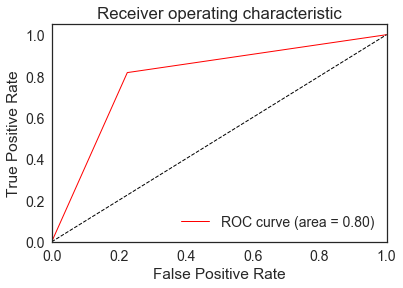

In [77]:
# ROC curve - plot True Positive Rate against False Positive Rate
fpr, tpr, thresholds = roc_curve(predictions, y_test)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve: %f" % roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [78]:
def run_kfold(X, Y, model):
    
    kf = KFold(n_splits=10) #n_splits previously n_folds
    
    outcomes = []
    fold = 0
    
    for train_index, test_index in kf.split(X):
        fold += 1
        X_train, X_test = X.values[train_index], X.values[test_index]
        Y_train, Y_test = Y.values[train_index], Y.values[test_index]
        
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        accuracy = accuracy_score(Y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))   
        
    mean_outcome = np.mean(outcomes)
    std_outcome=np.std(outcomes)
    var_outcome = np.var(outcomes)
    print("Mean r2: {0}".format(mean_outcome)) 
    print("Standard Deviation: {0}".format(std_outcome)) 
    print("Variance: {0}".format(var_outcome)) 
    
    return {'mean': mean_outcome, 'std': std_outcome, 'var': var_outcome, 'outcomes':outcomes}

In [79]:
def bias(y_predict,y):
    y_predict = np.array(y_predict)
    y = np.array(y)
    return np.mean(np.power((y_predict-y),2))

def variance(y_predict,y):
    y_predict = np.array(y_predict)
    return np.var(y_predict)

In [80]:
# # Tune Random Forest Classifier
model_RF = RandomForestClassifier(random_state = 42)
model_RF

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [81]:
model_RF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [82]:
result_model_RF = run_kfold(X_train,y_train, model_RF)

predictions_RF = model_RF.predict(X_test)
Test_Score_RF = accuracy_score(y_test, predictions_RF)

print ("------------------\nTest Score: " + str(Test_Score_RF))

Fold 1 accuracy: 0.873015873015873
Fold 2 accuracy: 0.873015873015873
Fold 3 accuracy: 0.6984126984126984
Fold 4 accuracy: 0.8387096774193549
Fold 5 accuracy: 0.8870967741935484
Fold 6 accuracy: 0.7903225806451613
Fold 7 accuracy: 0.7903225806451613
Fold 8 accuracy: 0.8225806451612904
Fold 9 accuracy: 0.7741935483870968
Fold 10 accuracy: 0.8064516129032258
Mean r2: 0.8154121863799283
Standard Deviation: 0.05394101802858996
Variance: 0.0029096334259606665
------------------
Test Score: 0.7985074626865671


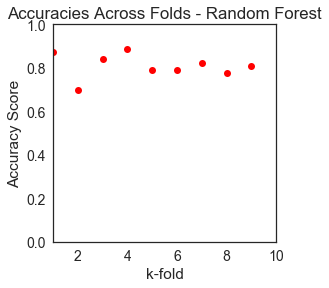

In [83]:
plt.figure(figsize=(4,4))
plt.plot(result_model_RF['outcomes'], 'ro')
plt.axis([1, 10, 0, 1])
plt.ylabel('Accuracy Score')
plt.xlabel('k-fold')
plt.title('Accuracies Across Folds - Random Forest')
plt.show()

In [98]:
# Bias variance trade off
max_depth_RF_classifier = np.arange(2,25)
accuracy_RF_list = []
bias_RF_list = []
var_RF_list = []
total_RF_list = []
err_RF_classification_test = []
err_RF_classification_training = []
err_tot_RF_classification_list = []
score_RF_classification_test = []
score_RF_classification_training = []
score_RF_accuracy_score = []

model_RF = RandomForestClassifier(random_state = 42)

for entry in max_depth_RF_classifier:
    model_RF.set_params(max_depth=entry)
    model_RF.fit(X_train, y_train)
    predicted_y_RF_classifier_test = model_RF.predict(X_test)
    predicted_y_RF_classifier_train = model_RF.predict(X_train)
    
    # Bias and variance estimate
    bias_variable = bias(predicted_y_RF_classifier_test, y_test)
    variance_variable = variance(predicted_y_RF_classifier_test, y_test)
    
    bias_RF_list.append(bias_variable)
    var_RF_list.append(variance_variable)
    
    total_RF_classification = bias_variable + variance_variable
    total_RF_list.append(total_RF_classification)
    
    # Training and test estimate
    err_RF_variable_test = mean_squared_error(y_test, predicted_y_RF_classifier_test)
    err_RF_variable_train = mean_squared_error(y_train, predicted_y_RF_classifier_train)
    err_RF_tot = err_RF_variable_test + err_RF_variable_train
    err_RF_classification_test.append(err_RF_variable_test)
    err_RF_classification_training.append(err_RF_variable_train)
    err_tot_RF_classification_list.append(err_RF_tot)

    # Score
    predictions_test = model_RF.predict(X_test)
    predictions_training = model_RF.predict(X_train)
    
    score_RF_classification_test.append(accuracy_score(y_test, predictions_test))
    score_RF_classification_training.append(accuracy_score(y_train, predictions_training))


In [99]:
max_depth_RF_classifier

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

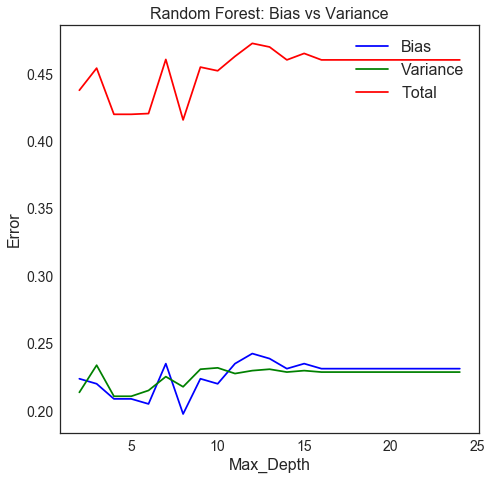

In [100]:
# Plot bias vs variance from changing the depth of the tree
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_RF_classifier, bias_RF_list,color = 'b')
plt.plot(max_depth_RF_classifier, var_RF_list,color = 'g')
plt.plot(max_depth_RF_classifier, total_RF_list,color = 'r')
plt.legend(['Bias', 'Variance', 'Total'], loc='upper right',fontsize = 16)
plt.title('Random Forest: Bias vs Variance',fontsize = 16)
plt.ylabel('Error',fontsize = 16)
plt.xlabel('Max_Depth',fontsize = 16)
# plt.ylim(4000, 15000)
plt.show()

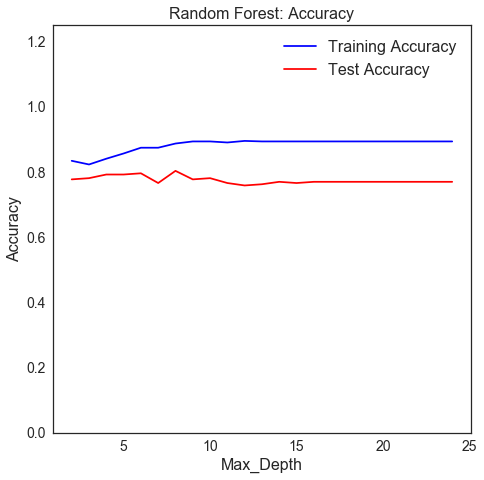

In [101]:
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_RF_classifier, score_RF_classification_training,color = 'b')
plt.plot(max_depth_RF_classifier, score_RF_classification_test,color = 'r')
plt.legend(['Training Accuracy', 'Test Accuracy'], loc='upper right',fontsize = 16)
plt.title('Random Forest: Accuracy',fontsize = 16)
plt.ylabel('Accuracy',fontsize = 16)
plt.xlabel('Max_Depth',fontsize = 16)
plt.ylim(0,1.25)
plt.show()

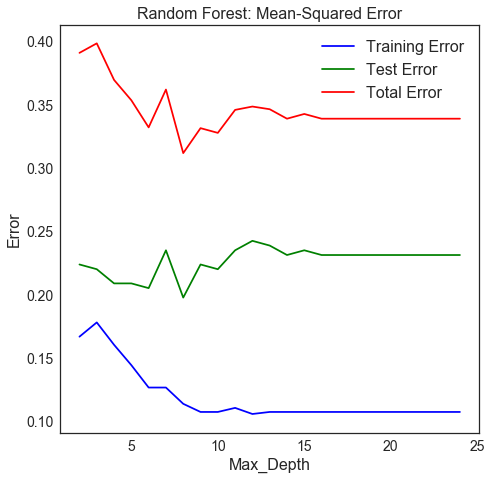

In [102]:
plt.figure(figsize=(7.5,7.5))
plt.plot(max_depth_RF_classifier, err_RF_classification_training,color = 'b')
plt.plot(max_depth_RF_classifier, err_RF_classification_test,color = 'g')
plt.plot(max_depth_RF_classifier, err_tot_RF_classification_list,color = 'r')
plt.legend(['Training Error', 'Test Error', 'Total Error'], loc='upper right',fontsize = 16)
plt.title('Random Forest: Mean-Squared Error',fontsize = 16)
plt.ylabel('Error',fontsize = 16)
plt.xlabel('Max_Depth',fontsize = 16)
#plt.ylim(0,0.01)
plt.show()

In [104]:
print("Depth\t Score")
for depth, score in zip(max_depth_RF_classifier, err_tot_RF_classification_list):
    print(depth, score)
    if depth == 25:
        break

Depth	 Score
2 0.3908147864210249
3 0.3983193981936226
4 0.36946886754030805
5 0.35341750317433696
6 0.3320296590881867
7 0.3618804053568434
8 0.3117258810282456
9 0.3314247382669318
10 0.3276933949833497
11 0.3458290409908723
12 0.34847631824824515
13 0.34635011140126015
14 0.33888742483409595
15 0.3426187681176781
16 0.33888742483409595
17 0.33888742483409595
18 0.33888742483409595
19 0.33888742483409595
20 0.33888742483409595
21 0.33888742483409595
22 0.33888742483409595
23 0.33888742483409595
24 0.33888742483409595


Based on the MSE, the optimal depth for the forest would be the parameter that yields min error, which is seen approximately around 13 depth. As the depth becomes greater, the training error is close to zero and remains constant, indicating that the model might be overfitting. 

### Hyperparameter turning of RF Classifier

In [90]:
# Let's use gridsearchCV to do hyperparameter tuning

In [106]:
RF_param = { 
        "n_estimators" : [10, 20, 40, 80, 100, 500, 2000],
        "min_samples_leaf": [1, 5, 10, 25, 50],
        "max_depth": [2, 4, 6, 8, 10],
        "max_features" : ["auto", "sqrt", "log2"],
        }

cv_model_RF = GridSearchCV(model_RF, cv = 5, param_grid = RF_param, n_jobs=-1, verbose=0)
cv_model_RF.fit(X_train, y_train)

print('Optimal parameters found: ')
print(cv_model_RF.best_params_)
print(cv_model_RF.best_estimator_)

optimal_RF = cv_model_RF.best_estimator_

result_model_RF_tuned = run_kfold(X_train, y_train, optimal_RF)
predictions_RF_tuned = optimal_RF.predict(X_test)
Test_Score_RF_tuned = accuracy_score(y_test, predictions_RF_tuned)

print("Test Score: ")
print(Test_Score_RF_tuned)

KeyboardInterrupt: 

# Preparing Kaggle submission

In [105]:
# Train optimal model using the entire training data set. Then use model to predict test input. 
test_data.isna().sum()

Pclass             0
Sex                0
Age                0
Fare               0
Embarked           0
family             0
Title              0
Age_times_Class    0
dtype: int64

In [ ]:
# Fit training set to model 


In [ ]:
data = {'PassengerId' : cleaned_test_data['PassengerId'], 
       'Survived': results}

In [ ]:
output = pd.DataFrame(data)

In [ ]:
output.to_csv(r'C:\Users\Francis\Desktop\Titanic\ML_Titanic_Kaggle\titanic_results.csv', index=False, header=True)